# Image Classification with DNN by using 6-dimensional concatenated tensor

In [1]:
!nvidia-smi

Fri Nov 19 15:02:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    16W / 240W |    474MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [15:02:17] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [6]:
path = Path('../dataset/oldsmiledata')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [8]:
IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_{dataset}.csv')
valid = pd.read_csv(path/f'test_{dataset}.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [10]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        1024 non-null   object 
 1   docked                          1024 non-null   object 
 2   rmsd                            1024 non-null   float64
 3   uniprot_id                      1024 non-null   object 
 4   smiles_template                 1024 non-null   object 
 5   smiles_docked                   1024 non-null   object 
 6   mcs_smartsString                1024 non-null   object 
 7   template_HeavyAtomCount         1024 non-null   int64  
 8   template_NHOHCount              1024 non-null   int64  
 9   template_NOCount                1024 non-null   int64  
 10  template_RingCount              1024 non-null   int64  
 11  template_NumHAcceptors          1024 non-null   int64  
 12  template_NumHDonors             10

# Create dataloader

In [11]:
from fastai.vision.all import *

In [12]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['image'] = train['template'] + train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [13]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['image'] = valid['template'] + valid['docked'] + '.png'
valid['is_valid'] = True
valid.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,img_temp,img_docked,image,is_valid
0,2C8Y_C3M,3SHC_B01,6.732,P00734,N[C@@H](Cc1ccccc1)[C@H](O)CNS(=O)(=O)c1ccc2ccccc2c1,N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCc1cc(Cl)ccn1,[#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6],26,4,5,...,0.240260,0.308219,1.906872,3,0.402597,0.082192,2C8Y_C3M.png,3SHC_B01.png,2C8Y_C3M3SHC_B01.png,True
1,2D1J_D01,1LPZ_CMB,7.109,P00742,O=C(c1cc2c(ccc[n+]2[O-])s1)N1CCN(S(=O)(=O)c2cc3cc(Cl)ccc3[nH]2)CC1,Cc1cccc2c1cc(C(=O)NCc1cc(Cl)cc(Cl)c1)n2Cc1cccc(C(=N)N)c1,"[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7](:,-[#6]-[#6]-[#7])-[#6]-[#6]):[#6]:[#6]",31,1,8,...,0.147959,0.203209,1.961362,3,-0.520408,-0.967914,2D1J_D01.png,1LPZ_CMB.png,2D1J_D011LPZ_CMB.png,True
2,4A7I_A7I,1NFX_RDR,7.520,P00742,CC(C)N1CCC(NS(=O)(=O)CCNC(=O)c2ccc(Cl)s2)CC1,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cnccc2n1CCO,"[#6]-[#6](-,:[#6])-,:[#7](-,:[#6]-,:[#6]-,:[#6]-,:[#7])-[#6]-[#6]",24,2,6,...,0.137143,0.177515,2.017566,3,-0.628571,-1.224852,4A7I_A7I.png,1NFX_RDR.png,4A7I_A7I1NFX_RDR.png,True
3,1ZGV_501,1C5O_BAM,3.197,P00734,CCCCNc1cc(C)nc2nc(Nc3cc(Cl)ccc3C)nn12,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-,:[#6](:[#6]:[#6]:[#6]:[#6]):,-[#6]",24,2,6,...,0.064815,0.127451,1.162213,3,-1.351852,-1.725490,1ZGV_501.png,1C5O_BAM.png,1ZGV_5011C5O_BAM.png,True
4,3DA6_BZ9,4W4V_3H8,11.188,P53779,CNc1nccc(-c2cccnc2Oc2c(C)cc(Nc3nc4ccccc4[nH]3)c3ccccc23)n1,Cc1cc(NC(=O)c2cccc(-n3cc(NC(=O)Nc4ccccc4Cl)cn3)c2)ccn1,"[#7]:[#6]:[#6](-,:[#7]-,:[#6]-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1):[#6]",36,3,8,...,0.190698,0.213270,2.414842,3,-0.093023,-0.867299,3DA6_BZ9.png,4W4V_3H8.png,3DA6_BZ94W4V_3H8.png,True


In [14]:
def stack_images(a, b):
    stack = torch.cat([tensor(Image.open(IMAGES/a)), tensor(Image.open(IMAGES/b))], dim=2).float()/255
    return stack

In [15]:
test = stack_images(train.img_temp[0], train.img_docked[0])
test.shape

torch.Size([224, 224, 6])

<AxesSubplot:>

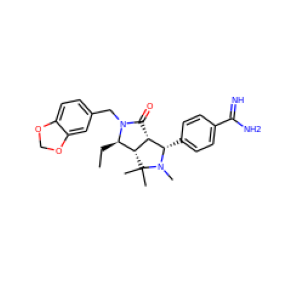

In [16]:
show_image(test[:, :, 0:3])

In [17]:
x = [stack_images(r.img_temp, r.img_docked) for i, r in train.iterrows()]

In [18]:
len(x)

23924

In [19]:
x[0].shape

torch.Size([224, 224, 6])

In [20]:
y = train['log_RMSD']
y.shape

(23924,)

In [21]:
dset = list(zip(x,y))
x1,y1 = dset[0]
x1.shape,y1

(torch.Size([224, 224, 6]), 1.53536070903778)

In [22]:
valid_x = [stack_images(r.img_temp, r.img_docked) for i, r in valid.iterrows()]
valid_y = valid['log_RMSD']
valid_dset = list(zip(valid_x, valid_y))

In [23]:
dl = DataLoader(dset, batch_size=64, shuffle=True)

In [24]:
valid_dl = DataLoader(valid_dset, batch_size=64, shuffle=True)

In [25]:
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([64, 224, 224, 6]), torch.Size([64]))

In [26]:
getters = [ColReader('img_temp', pref=IMAGES), ColReader('img_docked', pref=IMAGES), ColReader('rmsd')]

In [27]:
db = DataBlock(
    blocks = (ImageBlock(), ImageBlock(),  RegressionBlock()), 
    getters = getters,
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    n_inp=2,
    )

In [28]:
df = pd.concat([train, valid], ignore_index=True)

In [29]:
data = db.datasets(df)
data[0]

(PILImage mode=RGB size=224x224,
 PILImage mode=RGB size=224x224,
 tensor(4.6430))

In [30]:
df = pd.concat([train, valid], ignore_index=True)

In [31]:
df.is_valid.value_counts()

False    23924
True      1024
Name: is_valid, dtype: int64

In [32]:
df.smiles_template.nunique()

1030

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24948 entries, 0 to 24947
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        24948 non-null  object 
 1   docked                          24948 non-null  object 
 2   rmsd                            24948 non-null  float64
 3   uniprot_id                      24948 non-null  object 
 4   smiles_template                 24948 non-null  object 
 5   smiles_docked                   24948 non-null  object 
 6   mcs_smartsString                24948 non-null  object 
 7   template_HeavyAtomCount         24948 non-null  int64  
 8   template_NHOHCount              24948 non-null  int64  
 9   template_NOCount                24948 non-null  int64  
 10  template_RingCount              24948 non-null  int64  
 11  template_NumHAcceptors          24948 non-null  int64  
 12  template_NumHDonors             

# Create 6-dimensional PyTorch model

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [35]:
dls = DataLoaders(dl, valid_dl)

In [36]:
simple_net = nn.Sequential(
    nn.Conv2d(6, 64, ),
    nn.ReLU(),
    nn.Linear(30,1)
)

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=nn.MSELoss(), metrics=rmse)

In [ ]:
learn.fit(2, 0.01)

# Keras model

In [124]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing import DataGenerator
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense, Activation
from keras.utils import np_utils

ImportError: cannot import name 'DataGenerator'

In [78]:
def stack_images(a, b):
    stack = tf.concat([np.array(Image.open(IMAGES/a)), np.array(Image.open(IMAGES/b))], 2)
    return stack

In [114]:
test = stack_images(train.img_temp[0], train.img_docked[0])
test.shape

TensorShape([Dimension(224), Dimension(224), Dimension(6)])

<AxesSubplot:>

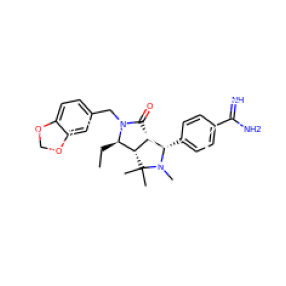

In [113]:
arr = test.eval(session=tf.compat.v1.Session())
img = Image.fromarray(arr[:, :, 0:4])
show_image(img)

In [146]:
x = [stack_images(r.img_temp, r.img_docked) for i, r in train.iterrows()]
x.shape

AttributeError: 'list' object has no attribute 'shape'

In [147]:
len(x)

23924

In [152]:
x_arr = np.array(x)
x_arr[0].shape

TensorShape([Dimension(224), Dimension(224), Dimension(6)])

In [117]:
y = train['log_RMSD']
y.shape

(23924,)

In [118]:
dset = list(zip(x,y))
x1,y1 = dset[0]
x1.shape,y1

(TensorShape([Dimension(224), Dimension(224), Dimension(6)]), 1.53536070903778)

In [ ]:
params = {'dim': (224,224,6),
          'batch_size': 64,
          'n_classes': 6,
          'n_channels': 2,
          'shuffle': True}

In [121]:
generator = DataGenerator(x.index, x)

NameError: name 'DataGenerator' is not defined

In [154]:
model = Sequential()

model.add(Convolution2D(32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 6)))

model.add(Flatten())

model.add(Dense(2))

model.add(Activation('softmax'))

In [156]:
model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [157]:
dset[:]

[(<tf.Tensor 'concat_10:0' shape=(224, 224, 6) dtype=uint8>, 1.53536070903778),
 (<tf.Tensor 'concat_11:0' shape=(224, 224, 6) dtype=uint8>, 1.16595936212772),
 (<tf.Tensor 'concat_12:0' shape=(224, 224, 6) dtype=uint8>,
  0.5704144151776479),
 (<tf.Tensor 'concat_13:0' shape=(224, 224, 6) dtype=uint8>, 1.37194185489549),
 (<tf.Tensor 'concat_14:0' shape=(224, 224, 6) dtype=uint8>, 1.97643935409014),
 (<tf.Tensor 'concat_15:0' shape=(224, 224, 6) dtype=uint8>,
  1.5949332262312201),
 (<tf.Tensor 'concat_16:0' shape=(224, 224, 6) dtype=uint8>, 2.02920032524309),
 (<tf.Tensor 'concat_17:0' shape=(224, 224, 6) dtype=uint8>, 2.26498706257873),
 (<tf.Tensor 'concat_18:0' shape=(224, 224, 6) dtype=uint8>,
  1.9947003132247498),
 (<tf.Tensor 'concat_19:0' shape=(224, 224, 6) dtype=uint8>,
  2.1344030997538104),
 (<tf.Tensor 'concat_20:0' shape=(224, 224, 6) dtype=uint8>,
  2.4501426573516603),
 (<tf.Tensor 'concat_21:0' shape=(224, 224, 6) dtype=uint8>, 2.28828330828319),
 (<tf.Tensor 'concat

In [158]:
model.fit(x_arr[0:32], y[0:32], verbose=1)

ValueError: Error when checking input: expected conv2d_6_input to have 4 dimensions, but got array with shape (32, 1)